In [14]:
%matplotlib inline

In [15]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [16]:
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
plt.rcParams['figure.figsize'] = (13, 9)

In [17]:
%%html
<style> 
table td, table th, table tr {text-align:left !important;}
</style>

# <center>521160P Johdatus Tekoälyyn<br><br>Harjoitus #5<br><br>Vahvistusoppiminen ja syväoppiminen<br><br>Kevät 2021</center>

Tässä harjoituksessa selvitetään Blackjack-korttipeliin pelistrategioita vahvistusoppimisella ja opetetaan konvoluutioneuroverkkoja kuvien luokkien tunnistamiseksi syväoppimisella. Harjoitus tulee palauttaa **26.4.2021 klo 23:59 mennessä. Lue huolellisesti palautukseen liittyvä ohjeistus tämän notebookin lopusta** (tämänkin harjoituksen palautusohjeet ovat hivenen erilaiset aiempien harjoituksien palautusohjeisiin verrattuna). Harjoituksesta on mahdollisuus saada 4 pistettä (2.0p + 2.0p).

Jos kohtaat ongelmia harjoitusta tehdessäsi tai sinulla on kysyttävää harjoitukseen liittyen ole yhteydessä Moodlesta löytyvän ohjelmointiharjoitus 4 foorumin kautta.

(*Jos käytät 32-bittistä järjestelmää ja sinulla on ongelmia tensorflow:n asentamisen kanssa, yksi vaihtoehto on poistaa nykyinen Python 3.7, asentaa [Miniconda3 (64-bit)](https://docs.conda.io/en/latest/miniconda.html) (asennuksen yhteydessä valitse asennettavaksi kaikille käyttäjille (All Users) ja lisää Miniconda3 PATH-ympäristömuuttujaan), aja järjestyksenvalvojana komentoriviltä komento conda install jupyter matplotlib numpy scikit-image scikit-learn ja komento conda install -c hesi_m tensorflow. Kyseinen tensorflow-versio on epävirallinen eikä tue tensorflow:n viimeisimpiä muutoksia. Sillä kuitenkin onnistuu käyttämään tensorflow:n perusfunktioita. Suorita tämä välivaihe ainoastaan, jos et saa asennettua tensorflow:ta ja järjestelmäsi on 32-bittinen.*)

# Tehtävä 1. Blackjack-korttipeli vahvistusoppimisella

Tässä tehtävässä selvitetään Blackjack-korttipeliin pelistrategioita vahvistusoppimisella. Käydään aluksi läpi pelin yksinkertaistetun version säännöt.

### Blackjack-korttipelin säännöt

Pelin alussa pelaajalle jaetaan kaksi korttia kuvapuoli ylöspäin ja jakajalle yksi kortti kuvapuoli ylöspäin ja yksi kortti kuvapuoli alaspäin. Blackjack-korttipelissä numerokortit 2-10 ovat numeronsa arvoisia, kuvakortit kymmenen arvoisia ja ässä on yksi tai yksitoista toiveesta riippuen. Pelaaja pelaa jakajaa vastaan ja hänen tavoiteensa on saada korttiensa summaksi suurempi kuin jakajan korttien summa. Korttien summan tulee olla mahdollisimman lähelle 21, mutta ei saa mennä yli, jolloin pelaaja häviää pelin. Jos pelaajan korttien summa kahdella aloituskortilla on 21 kuvan 1 tapaan, on hänellä blackjack. Tällä pelaaja voittaa jakajan kaikki muut kädet paitsi jakajan oman blackjackin, jolloin peli päättyy tasan. Pelaaja nostaa pakasta lisää kortteja, kunnes hän on tyytyväinen korttiensa summaan.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\blackjack.jpg' width='600' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 1. Blackjack-korttipelissa pelaajalla on aloituskädessä blackjack.</span>
</div>
<br>

Seuraavaksi vuoro siirtyy jakajalle. Jakajan tulee nostaa kortteja siihen asti, kunnes hänen korttiensa summa on 17 tai suurempi. Jos esimerkiksi jakajan korttien summa on 18 ja pelaajan korttien summa 19, pelaaja voittaa pelin. Pelaaja voittaa pelin myös silloin, kun jakajan korttien summa ylittää 21. Pelin päättyessä tasapeliin mahdolliset tulokset ovat 17-17, 18-18, 19-19, 20-20 tai 21-21.

Luodaan seuraavaksi pelin sääntöjen toteutumiseksi ja vahvistusoppimisalgoritmeja varten apufunktioita. 

In [18]:
def alusta_käsi():
    """
    Tässä funktiossa alustetaan käsi. Tyhjän käden korttien summa on 0, eikä se sisällä ässiä.
    """
    tyhjä_käsi = (0, False)
    return tyhjä_käsi

def onko_käyttämättömiä_ässiä(käsi):
    """
    Tässä funktiossa tarkistetaan, sisältääkö käsi käyttämättömiä ässiä.
    Ässä on vielä käytettävissä, jos käden korttien summa on alle 21 ja ässästä on käytetty arvoa 11.
    """
    korttien_summa, onko_ässiä = käsi    
    return (onko_ässiä and (korttien_summa + 10) <= 21)

def laske_korttien_summa(käsi):
    """
    Tässä funktiossa lasketaan käden korttien summa. Jos ässiä on käytettävissä, lisätään korttien summaan 10.
    """
    korttien_summa, onko_ässiä = käsi
    if onko_käyttämättömiä_ässiä(käsi):
        return korttien_summa + 10
    return korttien_summa

def päivitä_käsi(käsi, kortin_arvo):
    """
    Tässä funktiossa päivitetään käsi, kun siihen lisätään uusi kortti.
    """
    korttien_summa, onko_ässiä = käsi
    korttien_summa += kortin_arvo
    if kortin_arvo == 1:
        onko_ässiä = True
    päivitetty_käsi = (korttien_summa, onko_ässiä)
    return päivitetty_käsi
        
def arvo_kortti():
    """
    Tässä funktiossa arvotaan kortti äärettömän monta korttia sisältävästä pakasta.
    Arpomisen jälkeen jokaisella kortilla on siis edelleen sama todennäköisyys tulla valituksi. 
    ässä on 1, numerokortit 2-10 ovat numeronsa arvoisia ja kuvakortit ovat 10.
    """
    kortin_arvo = random.randint(1,13)
    if (kortin_arvo > 10):
        kortin_arvo = 10
    return kortin_arvo

def jaa_pelaajan_aloituskäsi():
    """
    Tässä funktiossa jaetaan pelaajan aloituskäsi. 
    Pelistrategian kannalta on mielenkiintoista selvittää, miten pelaaja pelaa, kun hänen korttiensa summa on yli 11.
    """    
    käsi = alusta_käsi()
    for i in range(2):
        kortin_arvo = arvo_kortti()
        käsi = päivitä_käsi(käsi, kortin_arvo)
    while laske_korttien_summa(käsi) < 11:
        kortin_arvo = arvo_kortti()
        käsi = päivitä_käsi(käsi, kortin_arvo)
    return käsi

def jaa_jakajan_aloituskäsi():
    """
    Tässä funktiossa jaetaan jakajan aloituskäsi eli yksi kortti. 
    """    
    käsi = alusta_käsi()
    kortin_arvo = arvo_kortti()
    käsi = päivitä_käsi(käsi, kortin_arvo)
    return käsi, kortin_arvo

def pelaa_jakajan_vuoro(käsi):
    """
    Tässä funktiossa jakaja nostaa uuden kortin, kunnes hänen kätensä korttien summa on 17 tai suurempi.
    """    
    while laske_korttien_summa(käsi) < 17:
        kortin_arvo = arvo_kortti()
        käsi = päivitä_käsi(käsi, kortin_arvo)
    return käsi

def generoi_tilat():
    """
    Tässä funktiossa palautetaan listassa pelin kaikki mahdolliset tilat. Jakajan kortin arvo on väliltä 1-10, 
    pelaajan korttien summa on 11-21 ja pelaajan käsi joko sisältää ässiä tai ei.
    """
    tilat = []
    for jakajan_kortin_arvo in range(1,11):
        for pelaajan_korttien_summa in range(11,22):
            tilat.append((jakajan_kortin_arvo, pelaajan_korttien_summa, False))
            tilat.append((jakajan_kortin_arvo, pelaajan_korttien_summa, True))
    return tilat

def aloita_peli_tilasta(tila):
    """
    Tässä funktiossa aloitetaan peli, kun sille annetaan tieto tilasta pelin alussa.
    """
    jakajan_kortin_arvo, pelaajan_korttien_summa, onko_ässiä = tila
    if onko_ässiä:
        pelaajan_korttien_summa -= 10
    pelaajan_käsi = (pelaajan_korttien_summa, onko_ässiä)
    jakajan_käsi = alusta_käsi()
    jakajan_käsi = päivitä_käsi(jakajan_käsi, jakajan_kortin_arvo)
    return jakajan_kortin_arvo, jakajan_käsi, pelaajan_käsi

def alusta_tila_liike_taulukon_arvot():
    """
    Tässä funktiossa alustetaan nollilla tila-liike-taulukon arvot. Liike True tarkoittaa, että pelaaja nostaa uuden kortin ja 
    liike False, että pelaaja päättää vuoronsa ollen tyytyväinen kortteihinsa.
    """
    tilat = generoi_tilat()
    tila_liike_taulukko = {}
    for tila in tilat:
        tila_liike_taulukko[(tila,True)] = 0.0
        tila_liike_taulukko[(tila,False)] = 0.0
    return tila_liike_taulukko

def muunna_tila_kädestä(kortin_arvo, pelaajan_käsi):
    """
    Tässä funktiossa muunnetaan pelaajan käsi tilaksi.
    """
    pelaajan_korttien_summa = laske_korttien_summa(pelaajan_käsi)
    onko_ässiä = onko_käyttämättömiä_ässiä(pelaajan_käsi)
    return (kortin_arvo, pelaajan_korttien_summa, onko_ässiä)

def valitse_sattumanvarainen_tila(tilat):
    """
    Tässä funktiossa valitaan sattumanvaraisesti tila kaikista mahdollisista tiloista.
    """
    arvottu_indeksi = random.randint(0,len(tilat)-1)
    tila = tilat[arvottu_indeksi]
    return tila

def valitse_sattumanvarainen_liike():
    """
    Tässä funktiossa valitaan sattumanvaraisesti toinen liikkeistä uuden kortin nostaminen ja vuoron päättäminen.
    """
    arvottu_luku = random.randint(1,2)
    return arvottu_luku == 1

def valitse_paras_liike(Q, tila):
    """
    Tässä funktiossa valitaan Q-arvojen perusteella kahdesta mahdollisesta liikkeestä parempi.
    """
    if Q[(tila,True)] > Q[(tila,False)]:
        return True
    return False
    
def anna_pelille_palaute(pelaajan_käsi, jakajan_käsi):
    """
    Tässä funktiossa annetaan palaute pelin lopputulokselle.
    """
    pelaajan_korttien_summa = laske_korttien_summa(pelaajan_käsi)
    jakajan_korttien_summa = laske_korttien_summa(jakajan_käsi)
    if pelaajan_korttien_summa > 21:
        return -1
    if jakajan_korttien_summa > 21:
        return 1
    if pelaajan_korttien_summa < jakajan_korttien_summa:
        return -1
    if pelaajan_korttien_summa == jakajan_korttien_summa:
        return 0
    if pelaajan_korttien_summa > jakajan_korttien_summa:
        return 1

Ässillä on suuri vaikutus pelistrategiaan, joten on tärkeää erottaa erilleen tilanteet, kun pelaajan kädessä on ässiä ja kun niitä ei ole. 

Pelin tila sisältää kolme arvoa: jakajan aloituskäden kortin arvon, pelaajan käden korttien summan ja tiedon siitä, sisältääkö pelaajan käsi ässiä. Pelin tilassa pelaajalla on mahdollista tehdä kahdenlaisia liikkeitä: 1) nostaa yksi kortti lisää tai 2) päättää vuoronsa ollen tyytyväinen korttiensa summaan. Liikkeen valinta voidaan suorittaa sattumanvaraisesti tai käyttää valinnassa hyödyksi aiemmin opittua tietoa.

Pelin lopputulokselle annetaan palaute sen mukaan, miten se päättyi. Pelaajan voittaessa palaute on 1, pelin päättyessä tasan palaute on 0 ja jakajan voittaessa palaute on -1.

### Monte Carlo-simulaatio

Seuraavaksi suoritetaan Monte Carlo-simulaatio. Koska Blackjack-korttipeli on stationäärinen prosessi, käytetään oppimisnopeutena arvoa $\alpha = \frac{1}{N(S_{t}, A_{t})}$. Monte Carlo-simulaatio päivittää Q-arvot yhtälön 1 mukaisesti.

<br>
\begin{equation}
Q(S_{t}, A_{t}) \leftarrow Q(S_{t}, A_{t}) + \alpha \: (R_{t}-Q(S_{t}, A_{t})) \tag{1}
\end{equation}
<br>

Epsilon-greedy-strategia vuorottelee sattumanvaraisen ja parhaan liikkeen valinnan välillä esimerkiksi valitsemalla yhdeksän kymmenestä kerrasta parhaaksi havaittu liike ja yhden kymmenestä kerrasta sattumanvarainen liike.

Toteuta Monte Carlo-simulaation päivityssääntö Q-arvojen laskemiseksi ja epsilon-greedy-strategia liikkeen valitsemiseksi.

In [19]:
def päivitä_monte_carlo_simulaatiolla(N, Q, tila_liike_pari, R):
    """
    Tässä funktiossa päivitetään vierailtujen tila-liike parien lukumäärä taulukko N ja Q-taulukon arvot.
    """
    # Lisätään tila-liike parille vierailtujen tila-liike parien lukumäärä taulukkoon yksi
    N[tila_liike_pari] += 1
    #-------TÄHÄN SINUN KOODI--------
    # Päivitä tila-liike parille uusi Q-arvo Monte Carlo-simulaation päivityssäännöllä, kun alpha = 1/N[tila_liike_pari]
    alpha = 1 / N[tila_liike_pari]
    Q[tila_liike_pari] = Q[tila_liike_pari] + (alpha * (R - Q[tila_liike_pari]))
    #--------------------------------
    return N, Q

def käytä_epsilon_greedy_strategiaa(Q, tila, epsilon):
    """
    Tässä funktiossa käytetään epsilon-greedy strategiaa liikkeen valinnassa. 
    Epsilonin arvon osoittama prosenttiluku kertoo, kuinka usein valitaan sattumanvarainen liike. 
    Muutoin valitaan paras mahdollinen liike.
    """
    #-------TÄHÄN SINUN KOODI--------
    # Arvo liukuluku 0 ja 1 väliltä (Vihje: random.random())
    rnd = random.random()
    # Jos arvottu luku on pienempi kuin epsilon
    if rnd < epsilon:
        # Funktio palauttaaa sattumanvaraisesti valitun liikkeen eli funktion valitse_sattumanvarainen_liike()
        return valitse_sattumanvarainen_liike()
    # Muussa tapauksessa funktio palauttaa parhaan liikkeen eli funktion valitse_paras_liike(Q, tila)
    return valitse_paras_liike(Q, tila)
    #--------------------------------

def suorita_monte_carlo_simulaatio(iteraatioiden_lukumäärä, epsilon):
    """
    Tässä funktiossa suoritetaan Monte Carlo-simulaatio Blackjack-korttipelille.
    """  
    # Alustetaan nollilla tila-liike parien arvot ja kuinka montaa kertaa tila-liike pareissa on vierailtu
    Q = alusta_tila_liike_taulukon_arvot()
    N = alusta_tila_liike_taulukon_arvot()
    # Generoidaan tilat
    tilat = generoi_tilat()
    for i in range(iteraatioiden_lukumäärä):
        tila_liike_parit = []
        # Valitaan tila ja liike sattumanvaraisesti
        tila = valitse_sattumanvarainen_tila(tilat)
        liike = valitse_sattumanvarainen_liike()
        jakajan_kortin_arvo, jakajan_käsi, pelaajan_käsi = aloita_peli_tilasta(tila)
        # Lisätään tila-liike pari listaan
        tila_liike_parit.append((tila, liike))
        # Pelaaja nostaa uusia kortteja kunnes korttien summa on yli 21
        while liike:
            pelaajan_käsi = päivitä_käsi(pelaajan_käsi, arvo_kortti())
            if laske_korttien_summa(pelaajan_käsi) > 21:
                break
            tila = muunna_tila_kädestä(jakajan_kortin_arvo, pelaajan_käsi)
            liike = käytä_epsilon_greedy_strategiaa(Q, tila, epsilon)
            tila_liike_parit.append((tila, liike))
        # Jakajan vuoro pelata, kun pelaaja päättää vuoronsa
        jakajan_käsi = pelaa_jakajan_vuoro(jakajan_käsi)
        # Lasketaan palautteen arvo
        R = anna_pelille_palaute(pelaajan_käsi, jakajan_käsi)
        # Päivitetään Q-arvot
        for tila_liike_pari in tila_liike_parit:
            N, Q = päivitä_monte_carlo_simulaatiolla(N, Q, tila_liike_pari, R)
    return Q

# Suoritetaan Monte Carlo-simulaatio
# Tämän välivaiheen ajaminen kestää hetken aikaa
Q_monte_carlo = suorita_monte_carlo_simulaatio(1000000, 0.1)

Piirretään Monte Carlo-simulaatiolla selvitetyt Q-arvot kolmiulotteiseen kuvaajaan liikkeille nosta uusi kortti ja päätä vuoro, kun pelaajan kädessä on ässiä ja kun niitä ei ole.

<ipython-input-20-9e9dcd5831e3>:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


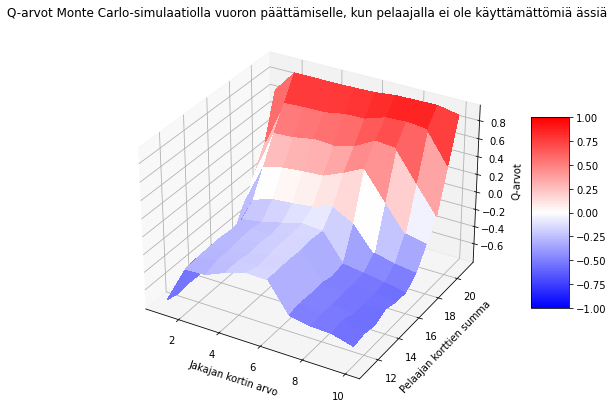

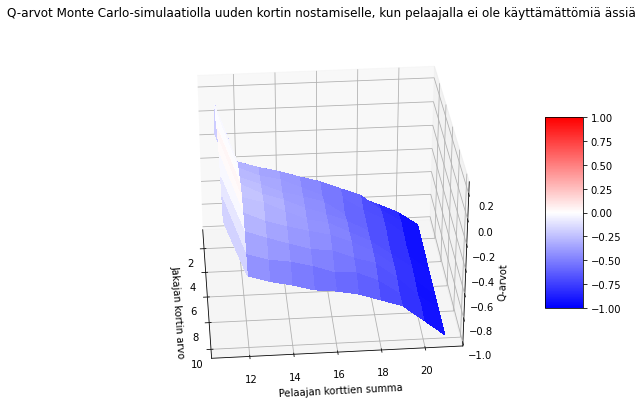

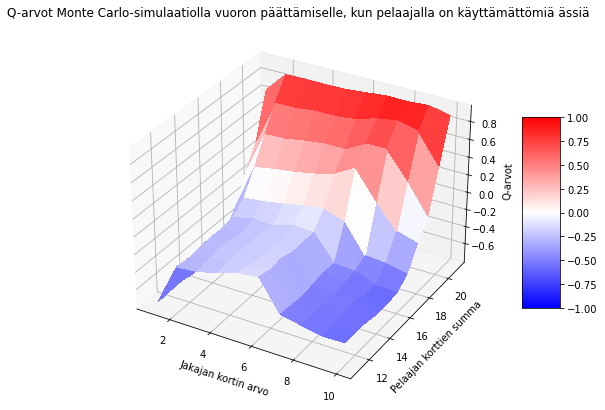

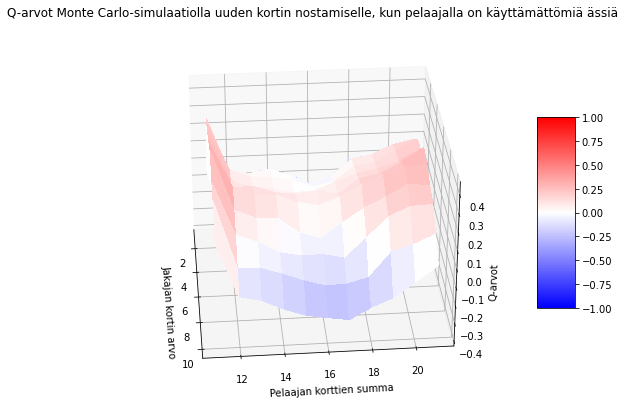

In [20]:
def piirrä_q_arvot_kuvaajaan(Q, X, Y, Z, otsikko, onko_ässiä, nosta_kortti, azim=-60):
    """
    Tässä funktiossa piirretään kolmiulotteiseen kuvaajaan Q-arvot määrätylle pelin liikkeelle ja ehdolle, onko kädessä ässiä.
    """
    for avain, Q_arvo in Q.items():
        if avain[0][2] == onko_ässiä and avain[1] == nosta_kortti:
            Z[avain[0][1]-11][avain[0][0]-1] = Q_arvo
    fig = plt.figure(figsize=(12,7))
    ax = fig.gca(projection='3d')
    ax.view_init(azim=azim)
    pinta = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, vmin=-1, vmax=1, cmap=cm.bwr, linewidth=0, antialiased=False)
    ax.set_ylabel('Pelaajan korttien summa')
    ax.set_xlabel('Jakajan kortin arvo')
    ax.set_zlabel('Q-arvot')
    ax.set_title(otsikko)
    fig.colorbar(pinta, shrink=0.5, aspect=5)

# Alustetaan kuvaajien akselien arvot
X = np.arange(1,11)
Y = np.arange(11,22)
Z = np.zeros((11,10))
X, Y = np.meshgrid(X, Y)

# Q-arvot Monte Carlo-simulaatiolla vuoron päättämiselle, kun pelaajalla ei ole käyttämättömiä ässiä
otsikko = 'Q-arvot Monte Carlo-simulaatiolla vuoron päättämiselle, kun pelaajalla ei ole käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_monte_carlo, X, Y, Z, otsikko, False, False)

# Q-arvot Monte Carlo-simulaatiolla uuden kortin nostamiselle, kun pelaajalla ei ole käyttämättömiä ässiä
otsikko = 'Q-arvot Monte Carlo-simulaatiolla uuden kortin nostamiselle, kun pelaajalla ei ole käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_monte_carlo, X, Y, Z, otsikko, False, True, azim=355)

# Q-arvot Monte Carlo-simulaatiolla vuoron päättämiselle, kun pelaajalla on käyttämättömiä ässiä
otsikko = 'Q-arvot Monte Carlo-simulaatiolla vuoron päättämiselle, kun pelaajalla on käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_monte_carlo, X, Y, Z, otsikko, True, False)

# Q-arvot Monte Carlo-simulaatiolla uuden kortin nostamiselle, kun pelaajalla on käyttämättömiä ässiä
otsikko = 'Q-arvot Monte Carlo-simulaatiolla uuden kortin nostamiselle, kun pelaajalla on käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_monte_carlo, X, Y, Z, otsikko, True, True, azim=355)
plt.show()

Tulostetaan Monte Carlo-simulaatiolla selvitetty pelistrategia valitsemalla tiloille tila-liike-taulukosta suuremman Q-arvon saanut liike.

In [21]:
def tulosta_pelistrategia(Q, algoritmin_nimi):
    """
    Tämä funktiossa tulostetaan pelistrategia valitsemalla liikkeistä suuremman Q-arvon saanut liike.
    """
    print('{}lla selvitetty pelistrategia (X nosta kortti, * päätä vuoro).\nPystyakselilla on pelaajan korttien summa ja vaaka-akselilla jakajan kortin arvo.'.format(algoritmin_nimi))
    for on_ässiä in [True, False]:
        if on_ässiä:
            print('\nPelaajalla on käyttämättömiä ässiä\n')
        else:
            print('\nPelaajalla ei ole käyttämättömiä ässiä\n')
        for pelaajan_käden_arvo in range(21,10,-1):
            for jakajan_kortti in range(1,11):
                if (Q[((jakajan_kortti,pelaajan_käden_arvo,on_ässiä),True)] > Q[((jakajan_kortti,pelaajan_käden_arvo,on_ässiä),False)]):
                    print(' X', end='')
                else:
                    print(' *', end='')
            print(' | {}'.format(pelaajan_käden_arvo))
        print('---------------------')
        print(' A 2 3 4 5 6 7 8 9 10')

# Tulostetaan Monte Carlo-simulaatiolla selvitetty pelistrategia
tulosta_pelistrategia(Q_monte_carlo, 'Monte Carlo-simulaatio')

Monte Carlo-simulaatiolla selvitetty pelistrategia (X nosta kortti, * päätä vuoro).
Pystyakselilla on pelaajan korttien summa ja vaaka-akselilla jakajan kortin arvo.

Pelaajalla on käyttämättömiä ässiä

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 X * * * * * * * X X | 18
 X X X X X X X X X X | 17
 X X X X X X X X X X | 16
 X X X X X X X X X X | 15
 X X X X X X X X X X | 14
 X X X X X X X X X X | 13
 X X X X X X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10

Pelaajalla ei ole käyttämättömiä ässiä

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 * * * * * * * * * * | 18
 * * * * * * * * * * | 17
 X * * * * * X X * * | 16
 X * * * * * X X X * | 15
 X * * * * * X X X X | 14
 X * * * * * X X X X | 13
 X X X * X * X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10


**Jos jakajan kortin arvo on 4, pelaajan korttien summa on 15 ja pelaajalla ei ole käyttämättömiä ässiä, mitä hänen kannattaa tehdä Monte Carlo-simulaatiolla selvitetyn pelistrategian perusteella?**

`Päättää vuoro.`

### Q-oppiminen

Seuraavaksi suoritetaan Q-oppiminen. Käytetään nyt oppimisnopeutena arvoa $\alpha = \frac{\alpha}{N(S_{t}, A_{t})}$. Q-oppiminen päivittää Q-arvot yhtälön 2 mukaisesti.

<br>
\begin{equation}
Q(S_{t},A_{t}) \leftarrow Q(S_{t},A_{t}) + \alpha \: [R_{t} + \gamma \max (Q(S_{t+1},A_{t})) - Q(S_{t},A_{t})] \tag{2}
\end{equation}
<br>

In [22]:
def suorita_q_oppiminen(iteraatioiden_lukumäärä, epsilon, oppimisnopeus):
    """
    Tässä funktiossa suoritetaan Q-oppimisalgoritmi Blackjack-korttipelille.
    """  
    # Alustetaan nollilla tila-liike parien arvot ja kuinka montaa kertaa tila-liike pareissa on vierailtu
    Q = alusta_tila_liike_taulukon_arvot()
    N = alusta_tila_liike_taulukon_arvot()
    # Generoidaan tilat
    tilat = generoi_tilat()
    for i in range(iteraatioiden_lukumäärä):
        # Valitaan tila sattumanvaraisesti
        tila = valitse_sattumanvarainen_tila(tilat)
        jakajan_kortin_arvo, jakajan_käsi, pelaajan_käsi = aloita_peli_tilasta(tila)
        while (True):
            # Valitaan liike epsilon-greedy-strategialla
            liike = käytä_epsilon_greedy_strategiaa(Q, tila, epsilon)
            tila_liike_pari = (tila, liike)
            if liike:
                # Pelaaja nostaa uusia kortteja kunnes korttien summa on yli 21
                kortin_arvo = arvo_kortti()
                pelaajan_käsi = päivitä_käsi(pelaajan_käsi, kortin_arvo)
                if laske_korttien_summa(pelaajan_käsi) > 21:
                    # Päivitetään Q-arvo
                    N[tila_liike_pari] += 1
                    Q[tila_liike_pari] += (oppimisnopeus/N[tila_liike_pari]) * ((-1) - Q[tila_liike_pari])
                    break
                else:
                    # Päivitetään Q-arvo
                    seuraava_tila = muunna_tila_kädestä(jakajan_kortin_arvo, pelaajan_käsi)
                    Q_arvo_maksimi = Q[(seuraava_tila,False)]
                    if (Q[(seuraava_tila,True)] > Q_arvo_maksimi):
                        Q_arvo_maksimi = Q[(seuraava_tila,True)]
                    N[tila_liike_pari] += 1
                    Q[tila_liike_pari] += (oppimisnopeus/N[tila_liike_pari]) * (Q_arvo_maksimi - Q[tila_liike_pari])
                    # Päivitetään tila
                    tila = seuraava_tila
            else:
                # Jakajan vuoro pelata, kun pelaaja päättää vuoronsa
                jakajan_käsi = pelaa_jakajan_vuoro(jakajan_käsi)
                # Lasketaan palautteen arvo
                R = anna_pelille_palaute(pelaajan_käsi, jakajan_käsi)
                # Päivitetään Q-arvo
                N[tila_liike_pari] += 1
                Q[tila_liike_pari] += (oppimisnopeus/N[tila_liike_pari]) * (R - Q[tila_liike_pari])
                break
    return Q

# Suoritetaan Q-oppiminen
# Tämän välivaiheen ajaminen kestää hetken aikaa
Q_q_oppiminen = suorita_q_oppiminen(1000000, 0.05, 0.999)

Piirretään Q-oppimisella selvitetyt Q-arvot kolmiulotteiseen kuvaajaan liikkeille nosta uusi kortti ja päätä vuoro, kun pelaajan kädessä on ässiä ja kun niitä ei ole.

<ipython-input-20-9e9dcd5831e3>:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


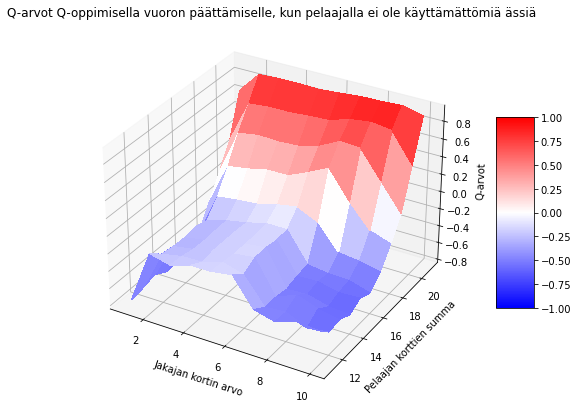

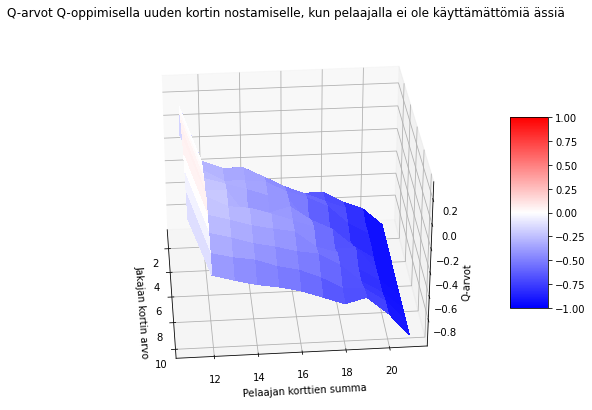

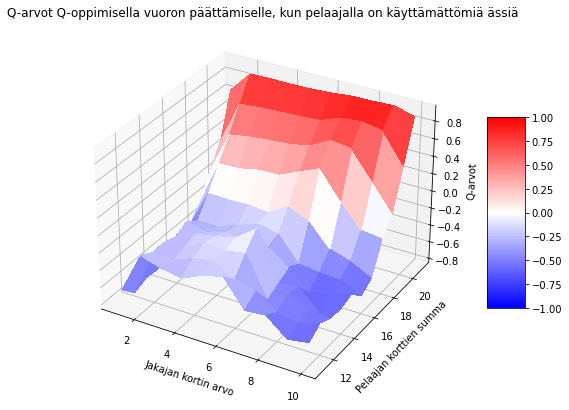

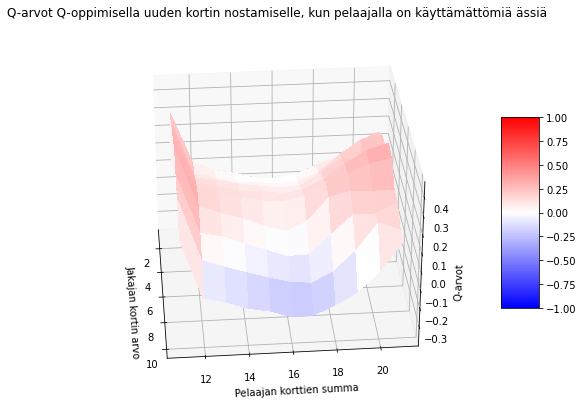

In [23]:
# Alustetaan kuvaajien akselien arvot
X = np.arange(1,11)
Y = np.arange(11,22)
Z = np.zeros((11,10))
X, Y = np.meshgrid(X, Y)

# Q-arvot Q-oppimisella vuoron päättämiselle, kun pelaajalla ei ole käyttämättömiä ässiä
otsikko = 'Q-arvot Q-oppimisella vuoron päättämiselle, kun pelaajalla ei ole käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_q_oppiminen, X, Y, Z, otsikko, False, False)

# Q-arvot Q-oppimisella uuden kortin nostamiselle, kun pelaajalla ei ole käyttämättömiä ässiä
otsikko = 'Q-arvot Q-oppimisella uuden kortin nostamiselle, kun pelaajalla ei ole käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_q_oppiminen, X, Y, Z, otsikko, False, True, azim=355)

# Q-arvot Q-oppimisella vuoron päättämiselle, kun pelaajalla on käyttämättömiä ässiä
otsikko = 'Q-arvot Q-oppimisella vuoron päättämiselle, kun pelaajalla on käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_q_oppiminen, X, Y, Z, otsikko, True, False)

# Q-arvot Q-oppimisella uuden kortin nostamiselle, kun pelaajalla on käyttämättömiä ässiä
otsikko = 'Q-arvot Q-oppimisella uuden kortin nostamiselle, kun pelaajalla on käyttämättömiä ässiä'
piirrä_q_arvot_kuvaajaan(Q_q_oppiminen, X, Y, Z, otsikko, True, True, azim=355)
plt.show()

Tulostetaan Q-oppimisella selvitetty pelistrategia valitsemalla tiloille tila-liike-taulukosta suuremman Q-arvon saanut liike.

In [24]:
# Tulostetaan Q-oppimisella selvitetty pelistrategia
tulosta_pelistrategia(Q_q_oppiminen, 'Q-oppimise')

Q-oppimisella selvitetty pelistrategia (X nosta kortti, * päätä vuoro).
Pystyakselilla on pelaajan korttien summa ja vaaka-akselilla jakajan kortin arvo.

Pelaajalla on käyttämättömiä ässiä

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 X * * * * * * * X X | 18
 X X X X X X X X X X | 17
 X X X X X X X X X X | 16
 X X X X X X X X X X | 15
 X X X X X X X X X X | 14
 X X X X X X X X X X | 13
 X X X X X X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10

Pelaajalla ei ole käyttämättömiä ässiä

 * * * * * * * * * * | 21
 * * * * * * * * * * | 20
 * * * * * * * * * * | 19
 * * * * * * * * * * | 18
 * * * * * * * * * * | 17
 X * * * * * X X X X | 16
 X * * * * * X X X X | 15
 X * * * * * X X X X | 14
 X * * * * * X X X X | 13
 X X * X * X X X X X | 12
 X X X X X X X X X X | 11
---------------------
 A 2 3 4 5 6 7 8 9 10


Eräs kasino lupaa palauttaa pelaajan pelipanoksen Blackjack-pelin voitosta kaksinkertaisena takaisin. Tasapelillä pelipanos palautetaan sellaisenaan takaisin ja häviöllä pelaaja menettää pelipanoksensa. 

Tarkastellaan lopuksi, kuinka hyvin selvitetyt pelistrategiat pärjäävät kyseisellä kasinolla palautusprosentin perusteella, kun molemmilla strategioilla pelataan 100 000 peliä.

In [25]:
def laske_palautusprosentti(Q, pelien_lukumäärä):
    """
    Tässä funktiossa lasketaan pelistrategialle palautusprosentti pelattaessa monta peliä peräkkäin.
    """
    palautus = 0
    tilat = generoi_tilat()
    for i in range(pelien_lukumäärä):
        tila = valitse_sattumanvarainen_tila(tilat)
        jakajan_kortin_arvo, jakajan_käsi, pelaajan_käsi = aloita_peli_tilasta(tila)
        while True:
            liike = valitse_paras_liike(Q, tila)
            tila_liike_pari = (tila, liike)
            if liike:
                # Pelaaja nostaa uusia kortteja kunnes korttien summa on yli 21
                kortti = arvo_kortti()
                pelaajan_käsi = päivitä_käsi(pelaajan_käsi, kortti)
                if laske_korttien_summa(pelaajan_käsi) > 21:
                    R = anna_pelille_palaute(pelaajan_käsi, jakajan_käsi)
                    palautus += R
                    break
            else:
                # Jakajan vuoro pelata, kun pelaaja päättää vuoronsa
                jakajan_käsi = pelaa_jakajan_vuoro(jakajan_käsi)
                # Lasketaan palautteen arvo
                R = anna_pelille_palaute(pelaajan_käsi, jakajan_käsi)
                palautus += R
                break
    return (pelien_lukumäärä + palautus)/pelien_lukumäärä

print('Palautusprosentti Monte Carlo-simulaatiolla selvitetylle pelistrategialle:  {} %\n'.format(round(100*laske_palautusprosentti(Q_monte_carlo, 100000),3)))
print('Palautusprosentti Q-oppimisella selvitetylle pelistrategialle: {} %\n'.format(round(100*laske_palautusprosentti(Q_q_oppiminen, 100000),3)))

Palautusprosentti Monte Carlo-simulaatiolla selvitetylle pelistrategialle:  64.807 %

Palautusprosentti Q-oppimisella selvitetylle pelistrategialle: 64.437 %



**Kumpi pelistrategioista on parempi? Kannattaako Blackjackin pelaaminen kyseisellä kasinolla näillä pelistrategioilla?**

`Monte Carlo on vain hieman parempi. Näillä palautusprosenteilla en lähtisi veikkaamaan.`

# Tehtävä 2. Konvoluutioneuroverkkojen opettaminen

Toisessa tehtävässä opetetaan kolme erilaista konvoluutioneuroverkkoa kuvien luokkien tunnistamiseksi. Tehtävässä käytetään CIFAR-10 dataa, jonka alkuperäinen versio sisältää 60 000 32x32 pikselin kokoista RGB-kuvaa objekteista, kuten henkilöautoista, linnuista ja kissoista. Yhteensä balansoidussa datassa on 10 luokkaa. Laskenta-ajan pienentämiseksi alkuperäisestä CIFAR-10 datasta on valittu 5000 opetusnäytettä ja 5000 validointinäytettä. Kuvassa 2 on esimerkkikuvia datan CIFAR-10 kaikista luokista.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\cifar10.png' width='950' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 2. Esimerkkikuvia datan CIFAR-10 kaikista luokista.</span>
</div>
<br>

Ladataan CIFAR-10 data ja jaetaan se opetusdataan ja validointidataan.

In [28]:
# Ladataan CIFAR-10 data
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
(data_opetus, luokat_opetus), (data_validointi, luokat_validointi) = cifar10.load_data()
data_opetus, luokat_opetus, data_validointi, luokat_validointi = data_opetus[:5000], luokat_opetus[:5000], data_validointi[:5000], luokat_validointi[:5000]
data_opetus, data_validointi = data_opetus.astype('float32'), data_validointi.astype('float32')
data_opetus /= 255
data_validointi /= 255

# Selvitetään luokkien lukumäärä
luokkien_lukumäärä = len(list(set(luokat_opetus.reshape(-1).tolist())))
luokkien_nimet = ['lentokone','henkilöauto','lintu','kissa','peura','koira','sammakko','hevonen','vene','kuorma-auto']

# Muunnetaan luokat kategoriseen muotoon one-hot-enkoodauksella
luokat_opetus_kategorinen = keras.utils.to_categorical(luokat_opetus, luokkien_lukumäärä)
luokat_validointi_kategorinen = keras.utils.to_categorical(luokat_validointi, luokkien_lukumäärä)

170500096/170498071 [==============================] - 21s 0us/step


Syväoppimisessa opetusdatan näytteet ajetaan opettamisen aikana useita kertoja neuroverkon läpi. Kun jokainen näyte on syötetty kerran neuroverkon läpi, on kulunut yksi jakso (engl. epoch). Usein näytteet ajetaan neuroverkon läpi erissä (engl. batch) sen sijaan, että ne syötettäisiin verkkoon yksi kerrallaan. Kun näyte-erästä opitaan, miten neuronien painokertoimia päivitetään, on kulunut yksi iteraatio. Jos esimerkiksi opetusdatassa on 1024 näytettä ja erän koko on 8 näytettä, yhden jakson aikana suoritetaan 128 iteraatiota.

Opetettavan mallin oppimisprosessia arvioidaan validointidatan ja opetusdatan luokittelutarkkuuksien ja häviöiden kehittymistä seuraamalla. Opetusdatan ja validointidatan luokittelutarkkuuksien välinen ero on suoraan verrannollinen ylioppimisen määrään. Kuvassa 3 sininen käyrä kuvaa validointidatan luokittelutarkkuutta ja sen arvo jää opetuksen edetessä paljon pienemmäksi kuin punaisen käyrän opetusdatan luokittelutarkkuus. Yksinkertaistamalla opetettua konvoluutioneuroverkkoa vihreän käyrän validointidatan luokittelutarkkuus on koko opetusprosessin ajan vain hivenen pienempi kuin opetusdatan luokittelutarkkuus, jolloin ylioppiminen on vähäistä. Häviöitä tarkastelemalla selvä merkki ylioppimiselle on, kun opetuksen edetessä opetusdatan häviö pienenee mutta validointidatan häviö alkaa selvästi kasvamaan. Opettaminen on syytä lopettaa, kun validointidatan luokittelutarkkuus saavuttaa maksiminsa ja validointidatan häviö miniminsä.

<br>
<div style="width:image width px; font-size:80%; text-align:center;">
    <center>
    <img src='kuvat\luokittelutarkkuus.png' width='350' height='auto' style='padding-bottom:0.5em;' />
    </center>
    <span>Kuva 3. Opetusdatan ja validointidatan luokittelutarkkuuksien välinen ero on suoraan verrannollinen ylioppimisen määrään.</span>
</div>
<br>

Tehtäväsi on luoda ja opettaa kolme erilaista konvoluutioneuroverkkoa ja arvioida niiden suorituskykyä. Mallien malli 1, malli 2 ja malli 3 rakenteet löytyvät taulukosta 1. Mallissa 1 on käytetty kahta konvoluutiokerroksen, aktivointifunktion ja maksiarvo-alinäytteistyskerroksen muodostamaa lohkoa. Mallissa 2 on lisäksi neuronien-pudotuskerroksia ja mallissa 3 normalisointeja erän suhteen. Taulukossa 1 jokaiselle kerrokselle löytyvät sulkujen sisältä piirteiden dimensio muunnoksen jälkeen.

Malli 1 on valmiiksi toteutettu esimerkkinä mallien 2 ja 3 toteuttamista varten. Käytä seuraavia keras-kirjaston funktioita lisättäessä malleihin kerroksia: konvoluutio ([Conv2D()](https://keras.io/layers/convolutional/)), aktivointifunktio ([Activation()](https://keras.io/layers/core/)), maksimiarvo-alinäytteistys ([MaxPooling2D()](https://keras.io/layers/pooling/)), neuronien-pudotuskerros ([Dropout()](https://keras.io/layers/core/)), normalisointi erän suhteen ([BatchNormalization()](https://keras.io/layers/normalization/)), syötekerros ([Flatten()](https://keras.io/layers/core/)), piilokerros ja lähtökerros ([Dense()](https://keras.io/layers/core/)).

<br>
<div style="width:image width px; font-size:80%; text-align:left;">
    <span>Taulukko 1. Tehtävässä käytettävien konvoluutioneuroverkkojen rakenteet</span>

| Malli 1 | Malli 2 | Malli 3 |
|   ---   |   ---   |   ---   |
| RGB-kuva (32x32x3) | RGB-kuva (32x32x3) | RGB-kuva (32x32x3) |
| <br> | <br> | <br> |
| 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) | 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) | 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) |
| ReLU-aktivointifunktio (32x32x32) | ReLU-aktivointifunktio (32x32x32) | ReLU-aktivointifunktio (32x32x32) |
| 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) | 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) | Normalisointi erän suhteen (32x32x32) |
| ReLU-aktivointifunktio (32x32x32) | ReLU-aktivointifunktio (32x32x32) | 3x3 konvoluutio, 32 kerrosta, nollarivillä (32x32x32) |
| 2x2 maksimiarvo-alinäytteistys (16x16x32) | 2x2 maksimiarvo-alinäytteistys (16x16x32) | ReLU-aktivointifunktio (32x32x32) |
| <br> | 30 % neuronien-pudotuskerros (16x16x32) | Normalisointi erän suhteen (32x32x32) |
| 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) | <br> | 2x2 maksimiarvo-alinäytteistys (16x16x32) |
| ReLU-aktivointifunktio (16x16x64) | 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) | 30 % neuronien-pudotuskerros (16x16x32) |
| 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) | ReLU-aktivointifunktio (16x16x64) | <br> |
| ReLU-aktivointifunktio (16x16x64) | 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) | 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) |
| 2x2 maksimiarvo-alinäytteistys (8x8x64) | ReLU-aktivointifunktio (16x16x64) | ReLU-aktivointifunktio (16x16x64) |
| <br> | 2x2 maksimiarvo-alinäytteistys (8x8x64) | Normalisointi erän suhteen (16x16x64) |
| Syötekerros (4096) | 40 % neuronien-pudotuskerros (8x8x64) | 3x3 konvoluutio, 64 kerrosta, nollarivillä (16x16x64) |
| Piilokerros (128) | <br> | ReLU-aktivointifunktio (16x16x64) |
| ReLU-aktivointifunktio (128) | Syötekerros (4096) | Normalisointi erän suhteen (16x16x64) |
| Lähtökerros (10) | Piilokerros (128) | 2x2 maksimiarvo-alinäytteistys (8x8x64) |
| Softmax-aktivointifunktio (10) | ReLU-aktivointifunktio (128) | 40 % neuronien-pudotuskerros (8x8x64) |
| <br> | 50 % neuronien-pudotuskerros (128) | <br> |
| <br> | Lähtökerros (10) | Syötekerros (4096) |
| <br> | Softmax-aktivointifunktio (10) | Piilokerros (128) |
| <br> | <br> | ReLU-aktivointifunktio (128) |
| <br> | <br> | Normalisointi erän suhteen (128) |
| <br> | <br> | 50 % neuronien-pudotuskerros (128) |
| <br> | <br> | Lähtökerros (10) |
| <br> | <br> | Softmax-aktivointifunktio (10) |
</div>
<br>

Luodaan esimerkkinä konvoluutioneuroverkko malli 1 ja opetetaan sitä CIFAR-10 datalla 20 jaksoa, kun erän koko on 64 näytettä. Voit pienentää erän kokoa (muuttujaa *batch_size*) esimerkiksi 32 tai 16 näytteeseen, mikäli tietokoneesi käyttömuisti on rajallinen. Piirretään kuvaajaan mallille 1 koko opetusprosessin opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt.

Model: "Malli_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
ReLU_1 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
ReLU_2 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 64)        18496     
_________________________________________________________________
ReLU_3 (Activation)          (None, 16, 16, 64)        0   

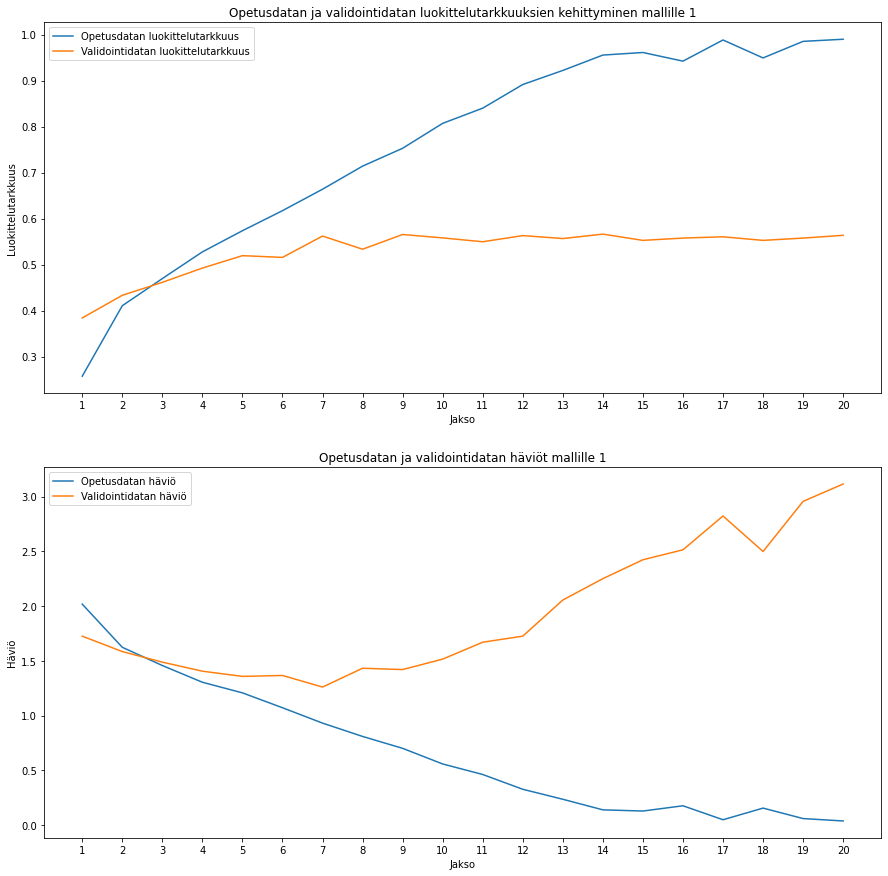

Opetusdatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 98.98 %
Validointidatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 56.36 %
Opetusdatan häviö 20 jakson opettamisen jälkeen on 0.038
Validointidatan häviö 20 jakson opettamisen jälkeen on 3.115


In [29]:
def piirrä_kuvaajaan_opetusprosessin_eteneminen(malli, mallin_nimi):
    """
    Tässä funktiossa piirretään kuvaajaan opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt opetuksen edetessä.
    """
    # Piirretään kuvaajaan koko opetusprosessin opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt
    fig, ax = plt.subplots(2, 1, figsize=(15,15))
    jaksot = np.arange(len(malli.history['accuracy']))+1
    ax[0].plot(jaksot, malli.history['accuracy'])
    ax[0].plot(jaksot, malli.history['val_accuracy'])
    opetusdatan_luokittelutarkkus = malli.history['accuracy'][-1]
    validointidatan_luokittelutarkkuus = malli.history['val_accuracy'][-1]
    opetusdatan_häviö = malli.history['loss'][-1]
    validointidatan_häviö = malli.history['val_loss'][-1]
    ax[0].set_title('Opetusdatan ja validointidatan luokittelutarkkuuksien kehittyminen mallille {}'.format(mallin_nimi))
    ax[0].set_xlabel('Jakso')
    ax[0].set_ylabel('Luokittelutarkkuus')
    ax[0].set_xticks(np.arange(len(malli.history['accuracy']))+1)
    ax[0].legend(['Opetusdatan luokittelutarkkuus', 'Validointidatan luokittelutarkkuus'], loc='upper left')
    
    ax[1].plot(jaksot, malli.history['loss'])
    ax[1].plot(jaksot, malli.history['val_loss'])
    ax[1].set_title('Opetusdatan ja validointidatan häviöt mallille {}'.format(mallin_nimi))
    ax[1].set_xlabel('Jakso')
    ax[1].set_ylabel('Häviö')
    ax[1].set_xticks(np.arange(len(malli.history['accuracy']))+1)
    ax[1].legend(['Opetusdatan häviö', 'Validointidatan häviö'], loc='upper left')
    plt.show()
    
    # Tulostetaan opettamisen jälkeen opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt
    print('Opetusdatan luokittelutarkkuus {} jakson opettamisen jälkeen on {} %'.format(jaksot.size, round(100*opetusdatan_luokittelutarkkus,3)))
    print('Validointidatan luokittelutarkkuus {} jakson opettamisen jälkeen on {} %'.format(jaksot.size, round(100*validointidatan_luokittelutarkkuus,3)))
    print('Opetusdatan häviö {} jakson opettamisen jälkeen on {}'.format(jaksot.size, round(opetusdatan_häviö,3)))
    print('Validointidatan häviö {} jakson opettamisen jälkeen on {}'.format(jaksot.size, round(validointidatan_häviö,3)))

def luo_malli1():
    """
    Tässä funktiossa luodaan konvoluutioneuroverkko malli 1.
    """
    # Alustetaan peräkkäisistä kerroksista koostuva malli
    malli1 = Sequential(name='Malli_1')
    malli1.add(Input(shape=(32,32,3)))

    # Lisätään 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli1.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Lisätään ReLU-aktivointifunktio
    malli1.add(Activation('relu', name='ReLU_1'))
    # Lisätään 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli1.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Lisätään ReLU-aktivointifunktio
    malli1.add(Activation('relu', name='ReLU_2'))
    # Lisätään 2x2 maksimiarvo-alinäytteistyskerros
    malli1.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))

    # Lisätään 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä
    malli1.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Lisätään ReLU-aktivointifunktio
    malli1.add(Activation('relu', name='ReLU_3'))
    # Lisätään 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä
    malli1.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Lisätään ReLU-aktivointifunktio
    malli1.add(Activation('relu', name='ReLU_4'))
    # Lisätään 2x2 maksimiarvo-alinäytteistyskerros
    malli1.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))

    # Lisätään syötekerros
    malli1.add(Flatten(name='Flatten_1'))
    # Lisätään piilokerros 128 neuronilla
    malli1.add(Dense(128, name='Dense_1'))
    # Lisätään ReLU-aktivointifunktio
    malli1.add(Activation('relu', name='ReLU_5'))
    # Lisätään lähtökerros 10 neuronilla
    malli1.add(Dense(10, name='Dense_2'))
    # Lisätään softmax-aktivointifunktio
    malli1.add(Activation('softmax', name='Softmax'))

    # Määritetään virhefunktioksi kategorinen ristientropia ja ADAM-optimisointi
    malli1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return malli1

# Luodaan malli 1
malli1 = luo_malli1()
print(malli1.summary())

# Opetetaan malli 1 ja piirretään kuvaajaan opetusprosessin eteneminen
# Tämän välivaiheen ajaminen kestää hetken aikaa
opetettu_malli1 = malli1.fit(data_opetus, luokat_opetus_kategorinen, batch_size=64, epochs=20, validation_data=(data_validointi, luokat_validointi_kategorinen), shuffle=True)
piirrä_kuvaajaan_opetusprosessin_eteneminen(opetettu_malli1, '1')

Luo malli 2, jota opetetaan CIFAR-10 datalla 20 jaksoa, kun erän koko on 64 näytettä. Voit pienentää erän kokoa (muuttuja *batch_size*) esimerkiksi 32 tai 16 näytteeseen, mikäli tietokoneesi käyttömuisti on rajallinen. Piirretään kuvaajaan mallille 2 koko opetusprosessin opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt.

Model: "Malli_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
ReLU_1 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
ReLU_2 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 16, 16, 32)        0         
_________________________________________________________________
Dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
Conv_3 (Conv2D)              (None, 16, 16, 64)        1849

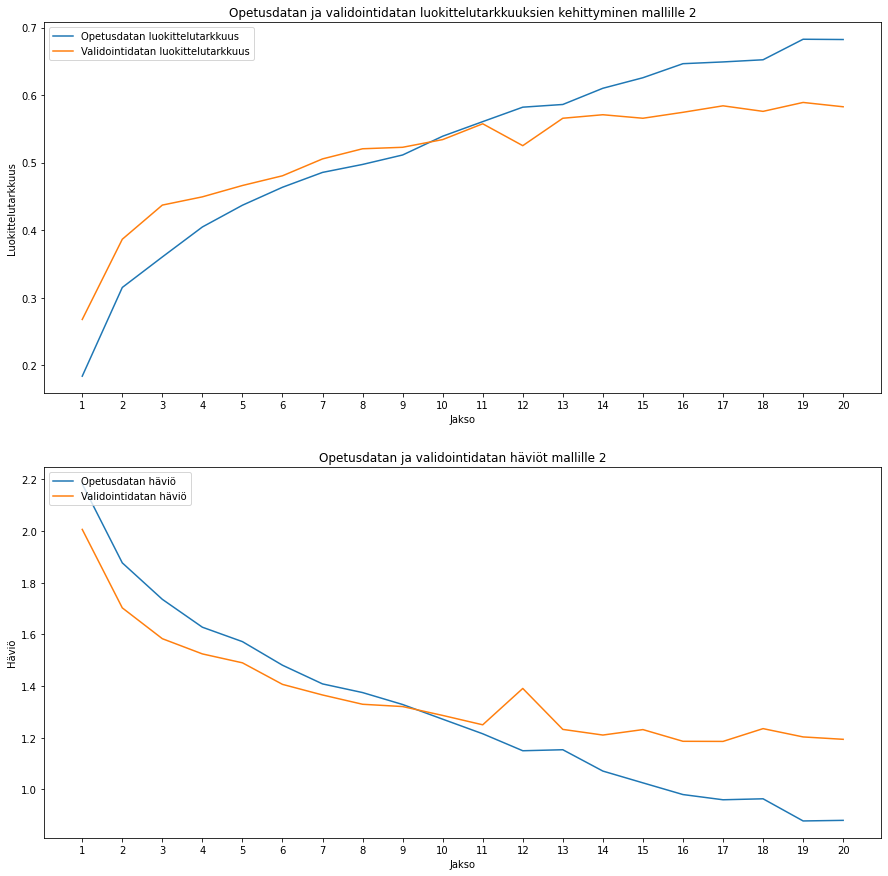

Opetusdatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 68.24 %
Validointidatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 58.28 %
Opetusdatan häviö 20 jakson opettamisen jälkeen on 0.88
Validointidatan häviö 20 jakson opettamisen jälkeen on 1.194


In [30]:
def luo_malli2():
    """
    Tässä funktiossa luodaan konvoluutioneuroverkko malli 2.
    """
    # Alustetaan peräkkäisistä kerroksista koostuva malli
    malli2 = Sequential(name='Malli_2')
    malli2.add(Input(shape=(32,32,3)))

    #-------TÄHÄN SINUN KOODI--------
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli2.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Lisää ReLU-aktivointifunktio
    malli2.add(Activation('relu', name='ReLU_1'))
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli2.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Lisää ReLU-aktivointifunktio
    malli2.add(Activation('relu', name='ReLU_2'))
    # Lisää 2x2 maksimiarvo-alinäytteistyskerros
    malli2.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))
    # Lisää 30 % neuronienpudotus-kerros
    malli2.add(Dropout(0.3, name='Dropout_1'))

    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä
    malli2.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Lisää ReLU-aktivointifunktio
    malli2.add(Activation('relu', name='ReLU_3'))
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä
    malli2.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Lisää ReLU-aktivointifunktio
    malli2.add(Activation('relu', name='ReLU_4'))
    # Lisää 2x2 maksimiarvo-alinäytteistyskerros
    malli2.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))
    # Lisää 40 % neuronienpudotus-kerros
    malli2.add(Dropout(0.4, name='Dropout_2'))

    # Lisää syötekerros
    malli2.add(Flatten(name='Flatten_1'))
    # Lisää piilokerros 128 neuronilla
    malli2.add(Dense(128, name='Dense_1'))
    # Lisää ReLU-aktivointifunktio
    malli2.add(Activation('relu', name='ReLU_5'))
    # Lisää 50 % neuronienpudotus-kerros
    malli2.add(Dropout(0.5, name='Dropout_3'))
    # Lisää lähtökerros 10 neuronilla
    malli2.add(Dense(10, name='Dense_2'))
    # Lisää softmax-aktivointifunktio
    malli2.add(Activation('softmax', name='Softmax'))
    #--------------------------------

    # Määritetään virhefunktioksi kategorinen ristientropia ja ADAM-optimisointi
    malli2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return malli2

# Luodaan malli 2
malli2 = luo_malli2()
print(malli2.summary())
               
# Opetetaan malli 2 ja piirretään kuvaajaan opetusprosessin eteneminen
# Tämän välivaiheen ajaminen kestää hetken aikaa
opetettu_malli2 = malli2.fit(data_opetus, luokat_opetus_kategorinen, batch_size=64, epochs=20, validation_data=(data_validointi, luokat_validointi_kategorinen), shuffle=True)
piirrä_kuvaajaan_opetusprosessin_eteneminen(opetettu_malli2, '2')

Luo malli 3, jota opetetaan CIFAR-10 datalla 20 jaksoa, kun erän koko on 64 näytettä. Voit pienentää erän kokoa (muuttuja *batch_size*) esimerkiksi 32 tai 16 näytteeseen, mikäli tietokoneesi käyttömuisti on rajallinen. Piirretään kuvaajaan mallille 3 koko opetusprosessin opetusdatan ja validointidatan luokittelutarkkuudet ja häviöt.

Model: "malli3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
ReLU_1 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
BatchNorm_1 (BatchNormalizat (None, 32, 32, 32)        128       
_________________________________________________________________
Conv_2 (Conv2D)              (None, 32, 32, 32)        9248      
_________________________________________________________________
ReLU_2 (Activation)          (None, 32, 32, 32)        0         
_________________________________________________________________
BatchNorm_2 (BatchNormalizat (None, 32, 32, 32)        128       
_________________________________________________________________
MaxPooling_1 (MaxPooling2D)  (None, 16, 16, 32)        0    

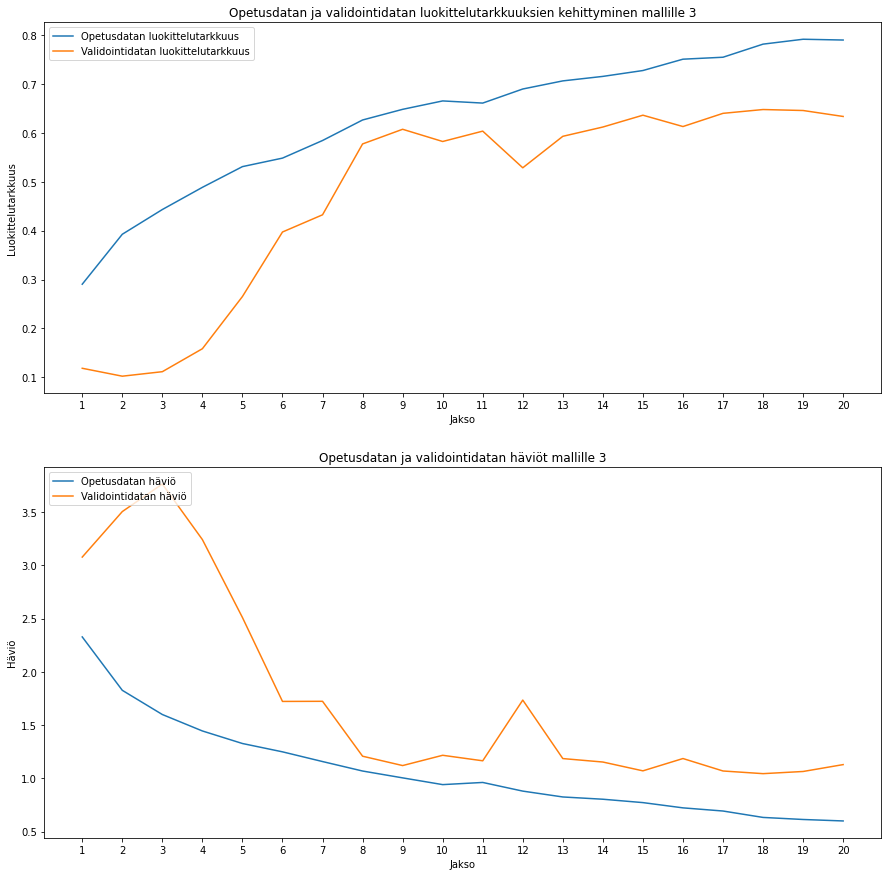

Opetusdatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 79.0 %
Validointidatan luokittelutarkkuus 20 jakson opettamisen jälkeen on 63.36 %
Opetusdatan häviö 20 jakson opettamisen jälkeen on 0.6
Validointidatan häviö 20 jakson opettamisen jälkeen on 1.129


In [31]:
def luo_malli3():
    """
    Tässä funktiossa luodaan konvoluutioneuroverkko malli 3.
    """
    # Alustetaan peräkkäisistä kerroksista koostuva malli
    malli3 = Sequential(name='malli3')
    malli3.add(Input(shape=(32,32,3)))

    #-------TÄHÄN SINUN KOODI--------
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli3.add(Conv2D(32, (3,3), padding='same', name='Conv_1'))
    # Lisää ReLU-aktivointifunktio
    malli3.add(Activation('relu', name='ReLU_1'))
    # Lisää normalisointi erän suhteen
    malli3.add(BatchNormalization(name = 'BatchNorm_1'))
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 32 kerrosta piirteitä
    malli3.add(Conv2D(32, (3,3), padding='same', name='Conv_2'))
    # Lisää ReLU-aktivointifunktio
    malli3.add(Activation('relu', name='ReLU_2'))
    # Lisää normalisointi erän suhteen
    malli3.add(BatchNormalization(name = 'BatchNorm_2'))
    # Lisää 2x2 maksimiarvo-alinäytteistyskerros
    malli3.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_1'))
    # Lisää 30 % neuronienpudotus-kerros
    malli3.add(Dropout(0.3, name='Dropout_1'))

    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä               
    malli3.add(Conv2D(64, (3,3), padding='same', name='Conv_3'))
    # Lisää ReLU-aktivointifunktio
    malli3.add(Activation('relu', name='ReLU_3'))
    # Lisää normalisointi erän suhteen
    malli3.add(BatchNormalization(name = 'BatchNorm_3'))
    # Lisää 3x3 konvoluutio nollarivin lisäyksellä, joka tuottaa 64 kerrosta piirteitä
    malli3.add(Conv2D(64, (3,3), padding='same', name='Conv_4'))
    # Lisää ReLU-aktivointifunktio
    malli3.add(Activation('relu', name='ReLU_4'))
    # Lisää normalisointi erän suhteen
    malli3.add(BatchNormalization(name = 'BatchNorm_4'))
    # Lisää 2x2 maksimiarvo-alinäytteistyskerros
    malli3.add(MaxPooling2D(pool_size=(2,2), name='MaxPooling_2'))
    # Lisää 40 % neuronienpudotus-kerros
    malli3.add(Dropout(0.4, name='Dropout_2'))

    # Lisää syötekerros
    malli3.add(Flatten(name='Flatten_1'))
    # Lisää piilokerros 128 neuronilla
    malli3.add(Dense(128, name='Dense_1'))
    # Lisää ReLU-aktivointifunktio
    malli3.add(Activation('relu', name='ReLU_5'))
    # Lisää normalisointi erän suhteen
    malli3.add(BatchNormalization(name = 'BatchNorm_5'))
    # Lisää 50 % neuronienpudotus-kerros
    malli3.add(Dropout(0.5, name='Dropout_3'))
    # Lisää lähtökerros 10 neuronilla
    malli3.add(Dense(10, name='Dense_2'))
    # Lisää softmax-aktivointifunktio
    malli3.add(Activation('softmax', name='Softmax'))
    #--------------------------------

    # Määritetään virhefunktioksi kategorinen ristientropia ja ADAM-optimisointi
    malli3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return malli3

# Luodaan malli 3
malli3 = luo_malli3()
print(malli3.summary())
               
# Opetetaan malli 3 ja piirretään kuvaajaan opetusprosessin eteneminen
# Tämän välivaiheen ajaminen kestää hetken aikaa
opetettu_malli3 = malli3.fit(data_opetus, luokat_opetus_kategorinen, batch_size=64, epochs=20, validation_data=(data_validointi, luokat_validointi_kategorinen), shuffle=True)
piirrä_kuvaajaan_opetusprosessin_eteneminen(opetettu_malli3, '3')

**Mikä opetetuista konvoluutioneuroverkkomalleista on paras? Mikä puolestaan opetetuista malleista on eniten ylioppinut?**

`Kolmas malli tuotti parhaan tuloksen validointidatalla, ensimmäinen malli on eniten ylioppinut.`

Mallien opettamisen jälkeen testataan niitä validointidatan 25 ensimmäisellä näytteellä. Piirretään kuvaan validointinäyte, mallilla sille ennustettu luokka, ennustetun luokan posterioritodennäköisyys ja suluissa näytteen oikea luokka. Kuvan tekstin väri on sininen, kun ennuste meni oikein ja punainen, kun se meni väärin. 

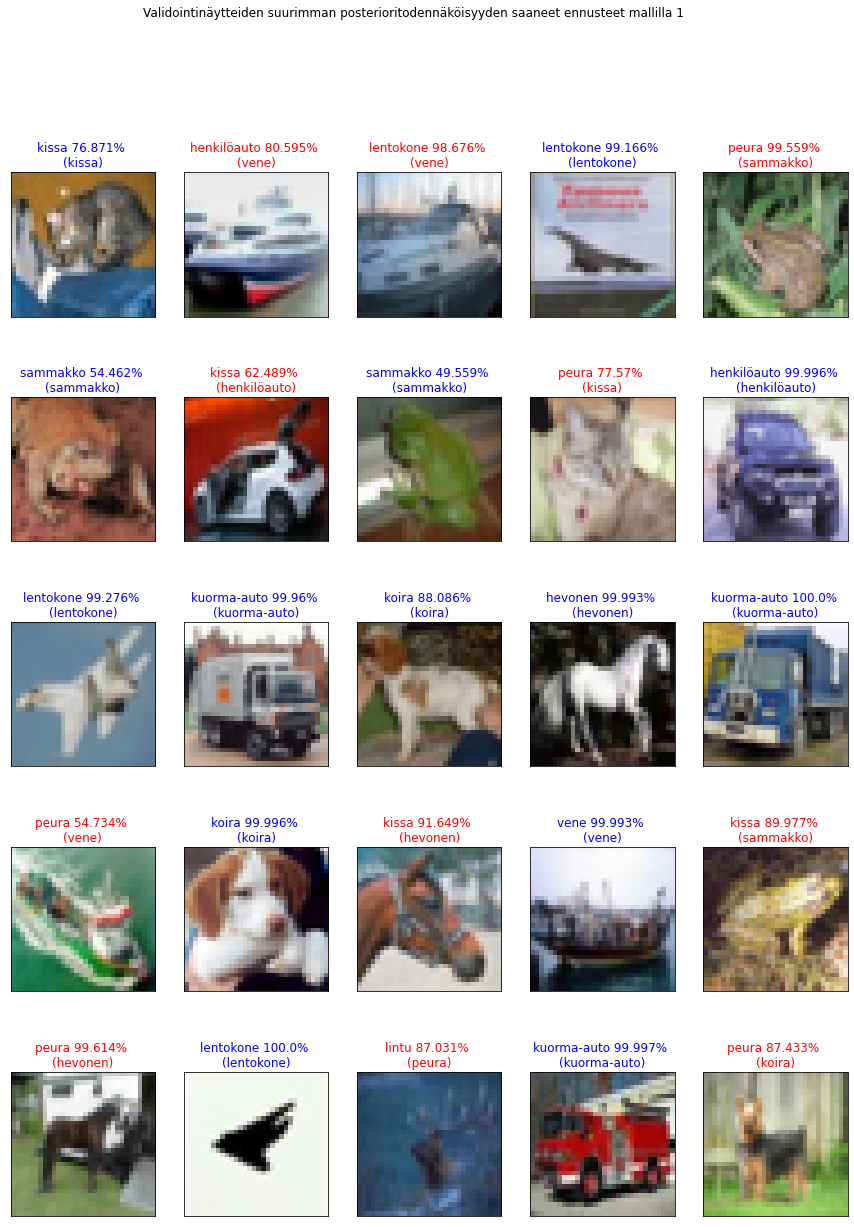

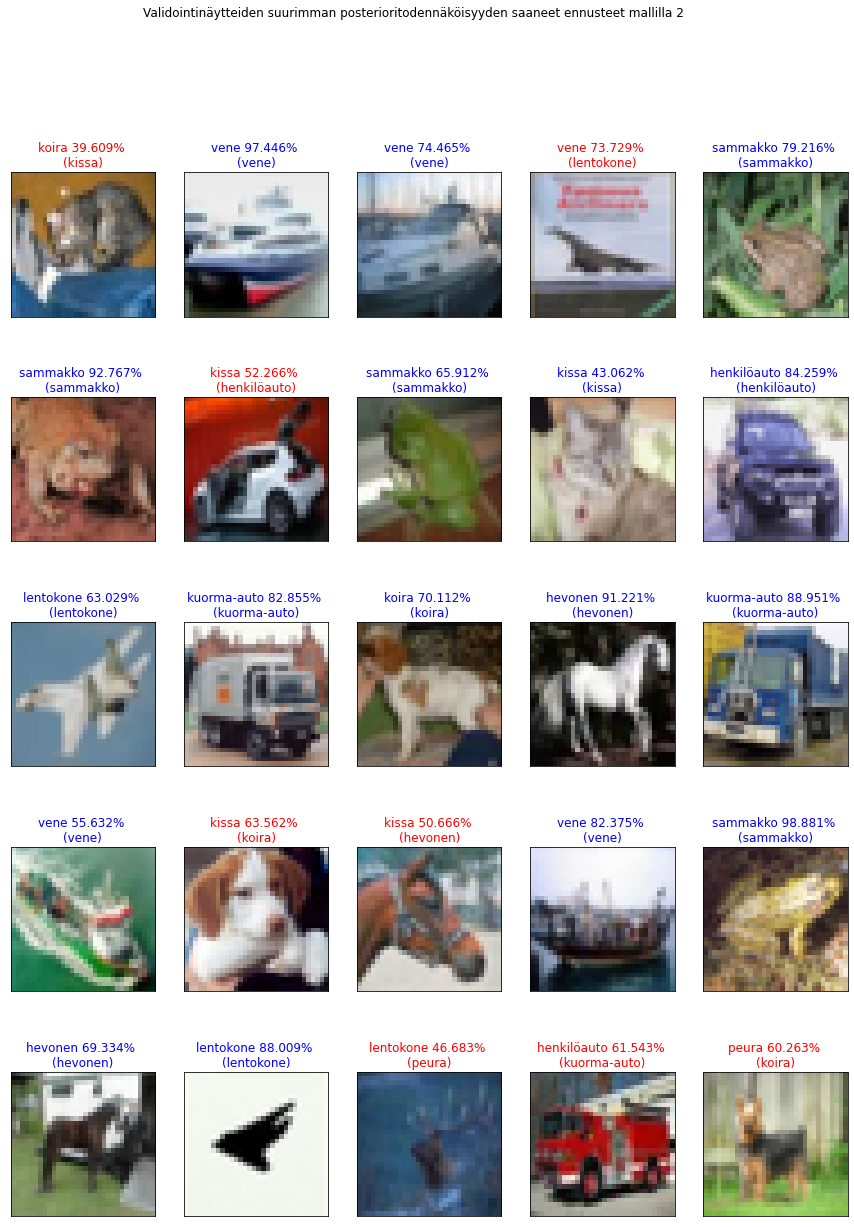

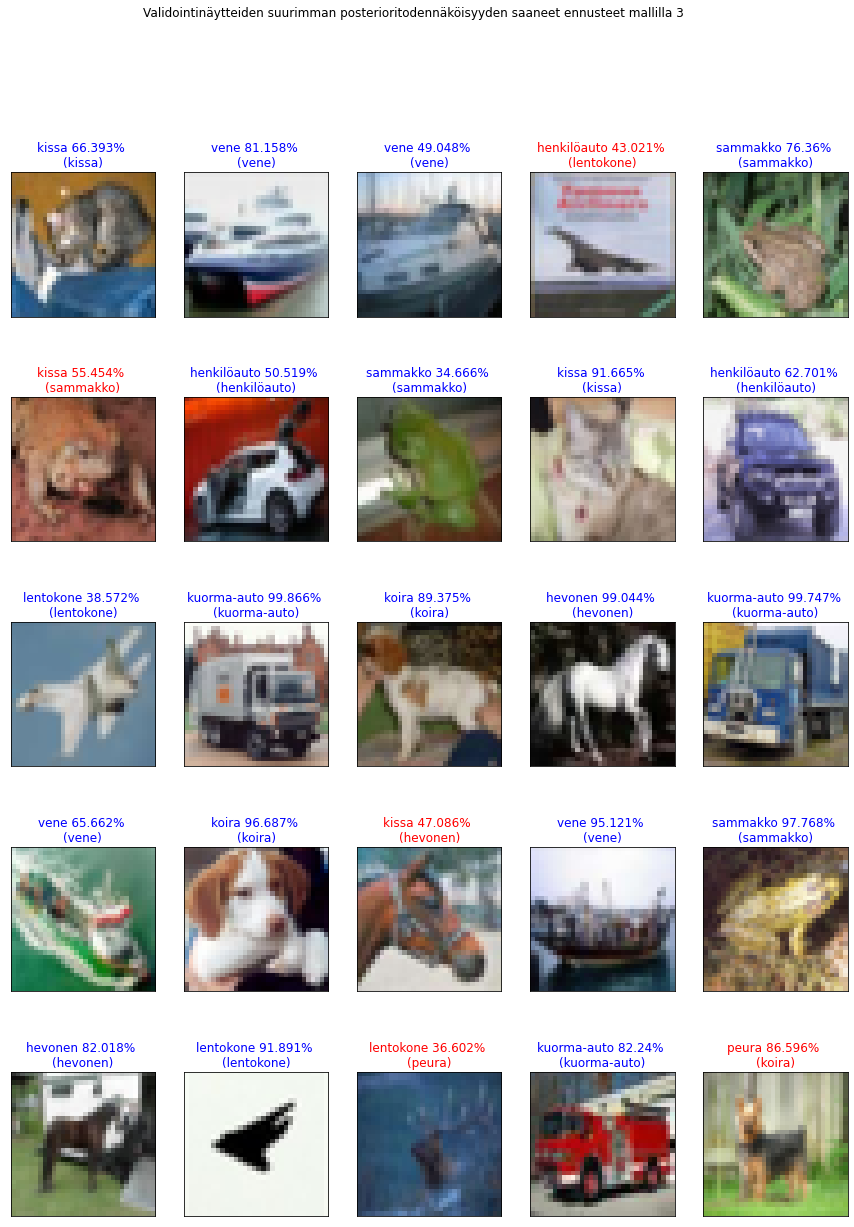

In [32]:
def tulosta_posterioritodennäköisyydet_ennusteille(malli, mallin_nimi, data_validointi, luokat_validointi, luokkien_nimet, rivien_lukumäärä, sarakkeiden_lukumäärä):
    """
    Tässä funktiossa ennustetaan mallilla testinäytteille posterioritodennäköisyydet todennäköisimmäksi luokaksi.
    """
    ennustetut_luokat = malli.predict(data_validointi)
    kuvien_lukumäärä = rivien_lukumäärä*sarakkeiden_lukumäärä   
    plt.figure(figsize=(3*sarakkeiden_lukumäärä, 4*rivien_lukumäärä)) 
    plt.suptitle('Validointinäytteiden suurimman posterioritodennäköisyyden saaneet ennusteet mallilla {} '.format(mallin_nimi))
    for i in range(kuvien_lukumäärä):
        plt.subplot(rivien_lukumäärä, sarakkeiden_lukumäärä, i+1)
        ennusteet, oikea_luokka, kuva = ennustetut_luokat[i], *luokat_validointi[i], data_validointi[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([]) 
        plt.imshow(kuva)
        ennustettu_luokka = np.argmax(ennusteet)
        if ennustettu_luokka == oikea_luokka:
            väri = 'blue'
        else:
            väri = 'red'
        plt.title('{} {}% \n({})'.format(luokkien_nimet[ennustettu_luokka], round(100*np.max(ennusteet),3), luokkien_nimet[oikea_luokka]), color=väri)

# Piirretään validointinäytteet kuvaan ja ennustetaan mallilla 1 luokaksi suurimman posterioritodennäköisyyden saanut
tulosta_posterioritodennäköisyydet_ennusteille(malli1, '1', data_validointi, luokat_validointi, luokkien_nimet, 5, 5)

# Piirretään validointinäytteet kuvaan ja ennustetaan mallilla 2 luokaksi suurimman posterioritodennäköisyyden saanut
tulosta_posterioritodennäköisyydet_ennusteille(malli2, '2', data_validointi, luokat_validointi, luokkien_nimet, 5, 5)

# Piirretään validointinäytteet kuvaan ja ennustetaan mallilla 3 luokaksi suurimman posterioritodennäköisyyden saanut
tulosta_posterioritodennäköisyydet_ennusteille(malli3, '3', data_validointi, luokat_validointi, luokkien_nimet, 5, 5)